<a href="https://colab.research.google.com/github/jiho01/Self-driving_AI/blob/main/0710_%EC%B0%A8%EC%84%A0%EA%B2%80%EC%B6%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. yt-dlp 설치

In [3]:
!pip install --upgrade yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 55.0 MB/s eta 0:00:00


# 2. 라이브러리

In [16]:
import cv2
import yt_dlp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display, clear_output
from google.colab.patches import cv2_imshow
import time
import os
import tempfile

# 3. 유튜브 영상 다운로드

In [14]:
def play_youtube_video(youtube_url, skip_frames=1):
    """
    YouTube 영상을 다운로드하고 재생하는 간단한 함수
    skip_frames: 프레임 건너뛰기 (1=모든 프레임, 2=한 프레임씩 건너뛰기)
    """

    ydl_opts = {
        'format': 'mp4/best[height<=480]',  # 480p로 제한 (빠른 처리)
        'outtmpl': tempfile.gettempdir() + '/temp_video.%(ext)s',
        'quiet': True,
    }

    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            print("⬇️ 영상 다운로드 중...")
            info = ydl.extract_info(youtube_url, download=True)

            video_path = ydl.prepare_filename(info)

            cap = cv2.VideoCapture(video_path)
            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            print(f"🎬 '{info['title']}' 재생 시작!")
            print("(Ctrl+C로 중단)")

            frame_num = 0
            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                # 프레임 건너뛰기
                if frame_num % skip_frames == 0:
                    clear_output(wait=True)
                    plt.figure(figsize=(10, 6))
                    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                    plt.title(f"재생 중... ({frame_num}/{frame_count})")
                    plt.axis('off')
                    plt.show()

                    # 재생 속도 조절
                    time.sleep(0.1)  # 0.1초 대기 (빠른 재생)

                frame_num += 1

            cap.release()
            os.remove(video_path)
            print("✅ 재생 완료!")

    except KeyboardInterrupt:
        print("\n⏹️ 재생 중단")
    except Exception as e:
        print(f"❌ 오류: {e}")

# 사용법
youtube_url = input("YouTube URL: ")
play_youtube_video(youtube_url, skip_frames=2)


⏹️ 재생 중단


<Figure size 1000x600 with 0 Axes>

#4. 차선 인식

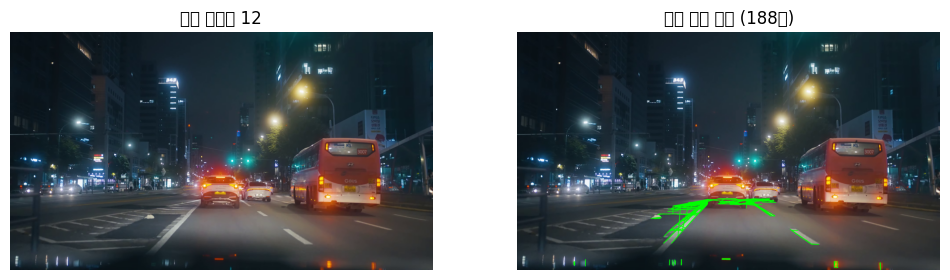


⏹️ 재생 중단


In [15]:
# 영상 업로드
#uploaded = files.upload()
video_path = "/content/강남대로 강남역 도로 드라이브 최근 밤거리 모습 입니다. [tEtWnGwwCEc].webm"

# 영상 열기
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"📹 영상 정보: {frame_count}프레임, {fps:.2f}FPS")
print("🎬 차선 인식 시작! (Ctrl+C로 중단)")

frame_num = 0
try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("📺 영상 재생 완료")
            break

        # 1. 그레이스케일 변환
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 2. 블러 → 에지(Canny) - 임계값 낮춤
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blur, 30, 100)  # 50,150 → 30,100

        # 3. ROI 설정 - 하단 30%
        height, width = edges.shape
        mask = np.zeros_like(edges)
        polygon = np.array([[
            (int(width * 0.1), height),            # 왼쪽 아래
            (int(width * 0.9), height),            # 오른쪽 아래
            (int(width * 0.6), int(height * 0.7)), # 오른쪽 위 (70% 지점)
            (int(width * 0.4), int(height * 0.7))  # 왼쪽 위 (70% 지점)
        ]])
        cv2.fillPoly(mask, polygon, 255)
        roi = cv2.bitwise_and(edges, mask)

        # 4. Hough Transform으로 직선 검출 - 파라미터 완화
        lines = cv2.HoughLinesP(roi, 2, np.pi / 180,
                               threshold=30,      # 50 → 30
                               minLineLength=30,  # 40 → 30
                               maxLineGap=80)     # 50 → 80

        # 5. 원본 프레임에 선 그리기
        line_image = frame.copy()
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)

        # 6. 결과 출력
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"원본 프레임 {frame_num}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
        plt.title(f"차선 인식 결과 ({len(lines) if lines is not None else 0}개)")
        plt.axis('off')
        plt.show()

        frame_num += 1
        time.sleep(10)  # 10초마다 이걸 바꿔본다.

except KeyboardInterrupt:
    print("\n⏹️ 재생 중단")

cap.release()

# # 미션1
1. 영상 저장 설정
2. 프레임 저장
3. output 리소스 정리
4. 결과 영상을 /content/lane_detection_result.mp4 에 저장

In [17]:
# 영상 열기
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"📹 영상 정보: {frame_count}프레임, {fps:.2f}FPS, 해상도: {width}x{height}")
print("🎬 차선 인식 시작! (Ctrl+C로 중단)")

# 결과 영상 저장 설정
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_path = "/content/lane_detection_result.mp4"
out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

frame_num = 0
try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("📺 영상 재생 완료")
            break

        # 1. 그레이스케일 변환
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 2. 블러 → 에지(Canny) - 임계값 낮춤
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blur, 30, 100)

        # 3. ROI 설정 - 하단 30%
        h, w = edges.shape
        mask = np.zeros_like(edges)
        polygon = np.array([[
            (int(w * 0.1), h),
            (int(w * 0.9), h),
            (int(w * 0.6), int(h * 0.7)),
            (int(w * 0.4), int(h * 0.7))
        ]])
        cv2.fillPoly(mask, polygon, 255)
        roi = cv2.bitwise_and(edges, mask)

        # 4. Hough Transform으로 직선 검출
        lines = cv2.HoughLinesP(roi, 2, np.pi / 180,
                                threshold=30,
                                minLineLength=30,
                                maxLineGap=80)

        # 5. 원본 프레임에 선 그리기
        line_image = frame.copy()
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)

        # 6. 결과 출력
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"원본 프레임 {frame_num}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
        plt.title(f"차선 인식 결과 ({len(lines) if lines is not None else 0}개)")
        plt.axis('off')
        plt.show()

        # 프레임 저장
        out.write(line_image)

        frame_num += 1
        time.sleep(10)  # 필요에 따라 조정

except KeyboardInterrupt:
    print("\n⏹️ 재생 중단")

# 리소스 정리
cap.release()
out.release()
print(f"✅ 결과 영상 저장 완료: {out_path}")

# Colab에서 결과 영상 다운로드
files.download(out_path)



⏹️ 재생 중단
✅ 결과 영상 저장 완료: /content/lane_detection_result.mp4


NameError: name 'files' is not defined

# # 미션2
- 각 프레임마다 종류 다르게 하기

In [21]:
# 영상 열기
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"📹 영상 정보: {frame_count}프레임, {fps:.2f}FPS")
print("🎬 차선 인식 시작! (Ctrl+C로 중단)")

max_frames = 20  # 20프레임만 처리
frame_num = 0

try:
    while frame_num < max_frames:
        ret, frame = cap.read()
        if not ret:
            print("📺 영상 재생 완료")
            break

        #1. 원본 프레임
        original = frame.copy()

        # 2. ROI boundary blue (파란 사다리꼴)
        roi_boundary = frame.copy()
        height, width = frame.shape[:2]
        polygon = np.array([[
            (int(width * 0.1), height),
            (int(width * 0.9), height),
            (int(width * 0.6), int(height * 0.7)),
            (int(width * 0.4), int(height * 0.7))
        ]])
        cv2.polylines(roi_boundary, polygon, isClosed=True, color=(255, 0, 0), thickness=3)

        # 1. 그레이스케일 변환
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 2. 블러 → 에지(Canny) - 임계값 낮춤
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blur, 30, 100)  # 50,150 → 30,100

        # 3. total edge detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blur, 30, 100)

        # 4. ROI mask
        mask = np.zeros_like(edges)
        cv2.fillPoly(mask, polygon, 255)
        roi_mask = mask.copy()

        # 5. ROI after edge
        roi = cv2.bitwise_and(edges, mask)

        # 6. detection total line (모든 직선)
        total_line = np.zeros_like(frame)
        lines = cv2.HoughLinesP(roi, 2, np.pi / 180, threshold=30, minLineLength=30, maxLineGap=80)
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(total_line, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # 7. filterling lane (필터링된 차선만)
        # 예시: 기울기 기준 필터링 (좌/우 차선 구분)
        filtered_line = np.zeros_like(frame)
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                slope = (y2 - y1) / (x2 - x1 + 1e-6)
                if abs(slope) > 0.5:  # 기울기 임계값 (필요시 조정)
                    cv2.line(filtered_line, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # 8. final result (원본 + 차선)
        final_result = frame.copy()
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                slope = (y2 - y1) / (x2 - x1 + 1e-6)
                if abs(slope) > 0.5:
                    cv2.line(final_result, (x1, y1), (x2, y2), (0, 255, 0), 3)


        # 9. 결과 출력
        clear_output(wait=True)
        plt.figure(figsize=(20, 10))

        # 윗줄
        plt.subplot(2, 4, 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title("original frame")
        plt.axis('off')

        plt.subplot(2, 4, 2)
        plt.imshow(cv2.cvtColor(roi_boundary, cv2.COLOR_BGR2RGB))
        plt.title("ROI boundary blue")
        plt.axis('off')

        plt.subplot(2, 4, 3)
        plt.imshow(edges, cmap='gray')
        plt.title("total edge detection")
        plt.axis('off')

        plt.subplot(2, 4, 4)
        plt.imshow(roi_mask, cmap='gray')
        plt.title("ROI mask")
        plt.axis('off')

        # 아랫줄
        plt.subplot(2, 4, 5)
        plt.imshow(roi, cmap='gray')
        plt.title("ROI after edge")
        plt.axis('off')

        plt.subplot(2, 4, 6)
        plt.imshow(cv2.cvtColor(total_line, cv2.COLOR_BGR2RGB))
        plt.title("detection total line")
        plt.axis('off')

        plt.subplot(2, 4, 7)
        plt.imshow(cv2.cvtColor(filtered_line, cv2.COLOR_BGR2RGB))
        plt.title("filterling lane")
        plt.axis('off')

        plt.subplot(2, 4, 8)
        plt.imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))
        plt.title("final result")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        frame_num += 1
        #time.sleep(1)  # 10초마다 이걸 바꿔본다.

except KeyboardInterrupt:
    print("\n⏹️ 재생 중단")
finally:
    cap.release()


⏹️ 재생 중단
